# Meta-Embedded Clustering (MEC)

In [1]:
# Import the librairies
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

import umap
from hdbscan.validity import validity_index

import torch
from torchvision import transforms
from torchvision.models import ResNet18_Weights, resnet18, VGG16_Weights, vgg16, DenseNet121_Weights, densenet121, AlexNet_Weights, alexnet
from torchvision.models.feature_extraction import create_feature_extractor

from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from kneed import KneeLocator

from config import load_config
from dataset import Darksound

from networks.protonet import PrototypicalNetworks
from networks.matchnet import MatchingNetworks
from networks.relatnet import RelationNetworks

import warnings
warnings.filterwarnings("ignore")

In [2]:
class Relation(torch.nn.Module):
    def __init__(self, backbone):
        super(Relation, self).__init__()
        self.backbone = backbone
        self.additional_layers = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d((1, 1)),torch.nn.Flatten())
    def forward(self, x):
        x = self.backbone(x)
        embedding = list(x.values())[0]
        x = self.additional_layers(embedding)
        return x

def get_features(model, spectrogram, device, params):
    # Extract the features from the model
    if params['PARAMS_MODEL']['NETWORK'] == 'relation':
        relation_features = Relation(model.backbone).to(device)
        features = relation_features(spectrogram.to(device).unsqueeze(dim=0))
    else:
        features = model.backbone.forward(spectrogram.to(device).unsqueeze(dim=0)).squeeze(dim=0)
    # Detach and convert to numpy array 
    return features.detach().cpu().numpy()

def evaluation(features, true_labels, clusterer):
    # Remove noisy samples indexes from pseudo and true labels
    pseudo_labels = clusterer.labels_
    clustered = pseudo_labels >= 0
    # Compute evaluation metrics
    ari = adjusted_rand_score(true_labels[clustered], pseudo_labels[clustered])
    ami = adjusted_mutual_info_score(true_labels[clustered], pseudo_labels[clustered])
    dbcv = validity_index(features.astype(np.float64), pseudo_labels, metric='euclidean')
    return ari, ami, dbcv 

## Import config file and load CNN backbones

In [3]:
# Import config file and load parameters
params = load_config("config.yaml")

# Set the seed for all random packages that could possibly be used
random_seed = params['RANDOM_SEED']
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------------------------------------
# LOAD THE CNN BACKBONE                
# -------------------------------------------------------------------------

# Use cuda if available for faster computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the backbones and the weights
if params['PARAMS_MODEL']['BACKBONE'] == 'resnet18':
    weights = ResNet18_Weights.IMAGENET1K_V1
    model = resnet18(weights=weights).to(device)
if params['PARAMS_MODEL']['BACKBONE'] == 'vgg16':
    weights = VGG16_Weights.IMAGENET1K_V1
    model = vgg16(weights=weights).to(device)
if params['PARAMS_MODEL']['BACKBONE'] == 'densenet':
    weights = DenseNet121_Weights.IMAGENET1K_V1
    model = densenet121(weights=weights).to(device)
if params['PARAMS_MODEL']['BACKBONE'] == 'alexnet':   
    weights = AlexNet_Weights.IMAGENET1K_V1
    model = alexnet(weights=weights).to(device)

bambird.extract_rois_full_sig


## Load the Darksound dataset and the meta-learning algorithms

In [4]:
# Load the Darksound dataset
test_set = Darksound(split='test', 
                    hpss=params['PARAMS_MODEL']['HPSS'], 
                    remove_background=params['PARAMS_MODEL']['REMOVE_BG'], 
                    transform=transforms.Compose([weights.transforms()]),
                    n_classes=30,
                    download=True,
                    )
# Get the ground truth labels
true_labels = np.array(test_set.__getlabel__())

# Get features shape and flatten classifier or fully connected layers
if params['PARAMS_MODEL']['BACKBONE'] == 'resnet18':
    features = np.zeros(shape=(len(test_set), model.fc.in_features))
    model.fc = torch.nn.Flatten()
elif params['PARAMS_MODEL']['BACKBONE'] == 'vgg16':
    features = np.zeros(shape=(len(test_set), 512))
    # Reduce vector size and computation in the network
    model.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
    model.classifier = torch.nn.Flatten()
elif params['PARAMS_MODEL']['BACKBONE'] == 'densenet':
    features = np.zeros(shape=(len(test_set), model.classifier.in_features))
    model.classifier = torch.nn.Flatten()
elif params['PARAMS_MODEL']['BACKBONE'] == 'alexnet':
    features = np.zeros(shape=(len(test_set), 256))
    # Reduce vector size and computation in the network
    model.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
    model.classifier = torch.nn.Flatten()
    
# Load the meta-learning algorithms
if params['PARAMS_MODEL']['NETWORK'] == 'matching':
    model = MatchingNetworks(model, use_softmax=True).to(device)
if params['PARAMS_MODEL']['NETWORK'] == 'prototypical':
    model = PrototypicalNetworks(model, use_softmax=True).to(device)
if params['PARAMS_MODEL']['NETWORK'] == 'relation':
    if params['PARAMS_MODEL']['BACKBONE'] == 'resnet18':
        model = create_feature_extractor(model, return_nodes=['layer4.1.bn2']) 
    if params['PARAMS_MODEL']['BACKBONE'] == 'vgg16':
        model = create_feature_extractor(model, return_nodes=['features.30'])
    if params['PARAMS_MODEL']['BACKBONE'] == 'densenet':
        model = create_feature_extractor(model, return_nodes=['features.norm5'])
    if params['PARAMS_MODEL']['BACKBONE'] == 'alexnet':
        model = create_feature_extractor(model, return_nodes=['features.12'])  
    model = RelationNetworks(model, use_softmax=False).to(device)

bambird.extract_rois_full_sig
Files already downloaded and verified


## Extract features from the CNN backbone

In [5]:
# Load pretrained model fune-tuned on pseudo labeled set
model_name = 'prototypical-networks-5way-1shot-densenet'
model.load_state_dict(torch.load(f'embeddings/{model_name}.pt', map_location=device)) 

# -------------------------------------------------------------------------
# EXTRACT FEATURES               
# -------------------------------------------------------------------------

for i in tqdm(range(len(test_set)), desc='Extracting features'):
    # Extracting features from the model
    features[i] = get_features(model, test_set[i][0], device, params) 
# Save the vector embeddings to disk
np.save(f'embeddings/features/{model_name}-30classes.npy', features)

Extracting features: 100%|██████████| 8163/8163 [13:47<00:00,  9.86it/s]


## Dimensionality reduction and clustering

In [6]:
# features = np.load('embeddings/features/prototypical-networks-5way-1shot-densenet-30classes.npy')
range_n_components = [5,10,15,20,25]

# -------------------------------------------------------------------------
# DIMENSIONALITY RECUCTION AND CLUSTERING               
# -------------------------------------------------------------------------

for n_components in range_n_components:
    # Reduce dimensionality of the latent space
    embedding = umap.UMAP(densmap=True, n_components=n_components, n_jobs=-1, random_state=random_seed).fit_transform(features)

    # Determine the parameters for DBSCAN (Sander et al., 1998)
    k = embedding.shape[1] * 2 - 1 
    # Calculate average distance between each point in the data set and its k-nearest neighbors (k corresponds to min_points).
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(embedding)
    distances, indices = neighbors_fit.kneighbors(embedding)
    # Sort distance values by ascending value and plot
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1] 
    # Find the knee (curvature inflexion point)
    kneedle = KneeLocator(
        x = np.arange(0, len(distances), 1),
        y = distances,
        interp_method = "polynomial",
        curve = "convex",
        direction = "increasing")
    eps = float(kneedle.knee_y)  

    # Perform DBSCAN clustering from embedding array
    clusterer = DBSCAN(min_samples=k, eps=eps).fit(embedding)
    # Get the predicted labels and the number of clusters
    pseudo_labels = clusterer.labels_ 
    clusters = len(np.unique(pseudo_labels[pseudo_labels >= 0])) # remove noisy samples
    percentage = int(round(np.sum(pseudo_labels >= 0) / features.shape[0], 2) * 100)
    print(f'\nClustering {percentage}% of the data: Found {clusters} clusters with n_components={n_components}.')

    ari, ami, dbcv = evaluation(embedding, true_labels, clusterer)
    print(f'ARI: {ari}\nAMI: {ami}\nDBCV: {dbcv}\n')


Clustering 67% of the data: Found 72 clusters with n_components=5.
ARI: 0.7087123065119176
AMI: 0.8015505935803061
DBCV: 0.1461771671061794


Clustering 54% of the data: Found 35 clusters with n_components=10.
ARI: 0.8375347164502641
AMI: 0.8671358285168507
DBCV: 0.18487589930343162


Clustering 44% of the data: Found 25 clusters with n_components=15.
ARI: 0.861899260262928
AMI: 0.9049505033280462
DBCV: 0.27455856760669933


Clustering 37% of the data: Found 19 clusters with n_components=20.
ARI: 0.9149179548187871
AMI: 0.9323003472445007
DBCV: 0.23264932376471217


Clustering 31% of the data: Found 15 clusters with n_components=25.
ARI: 0.8713651725412941
AMI: 0.9253706422762278
DBCV: 0.21564816799808587



## Plot the vector embeddings in two dimensions

Create a random colormap

Number of labels: 25


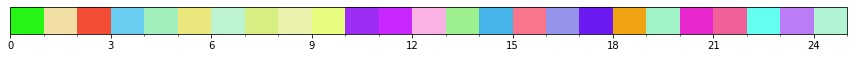

In [7]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

def plot_embedding(features_path, n_components=10):
    features = np.load(features_path)
    embedding = umap.UMAP(densmap=True, n_components=n_components, n_jobs=-1, random_state=random_seed).fit_transform(features)
    # Determine the parameters for DBSCAN (Sander et al., 1998)
    k = embedding.shape[1] * 2 - 1 
    # Calculate average distance between each point in the data set and its k-nearest neighbors (k corresponds to min_points).
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(embedding)
    distances, indices = neighbors_fit.kneighbors(embedding)
    # Sort distance values by ascending value and plot
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1] 
    # Find the knee (curvature inflexion point)
    kneedle = KneeLocator(
        x = np.arange(0, len(distances), 1),
        y = distances,
        interp_method = "polynomial",
        curve = "convex",
        direction = "increasing")
    eps = float(kneedle.knee_y)  

    # Perform DBSCAN clustering from embedding array
    clusterer = DBSCAN(min_samples=k, eps=eps).fit(embedding)
    # Get the predicted labels and the number of clusters
    labels = clusterer.labels_ 
    # Reduce dimensionality
    reduced_embedding = umap.UMAP(n_jobs=-1, n_components=2, random_state=random_seed).fit_transform(features)
    
    return labels, reduced_embedding 

new_cmap = rand_cmap(25, type='bright', first_color_black=False, last_color_black=False, verbose=True)

Load the vector embeddings and plot

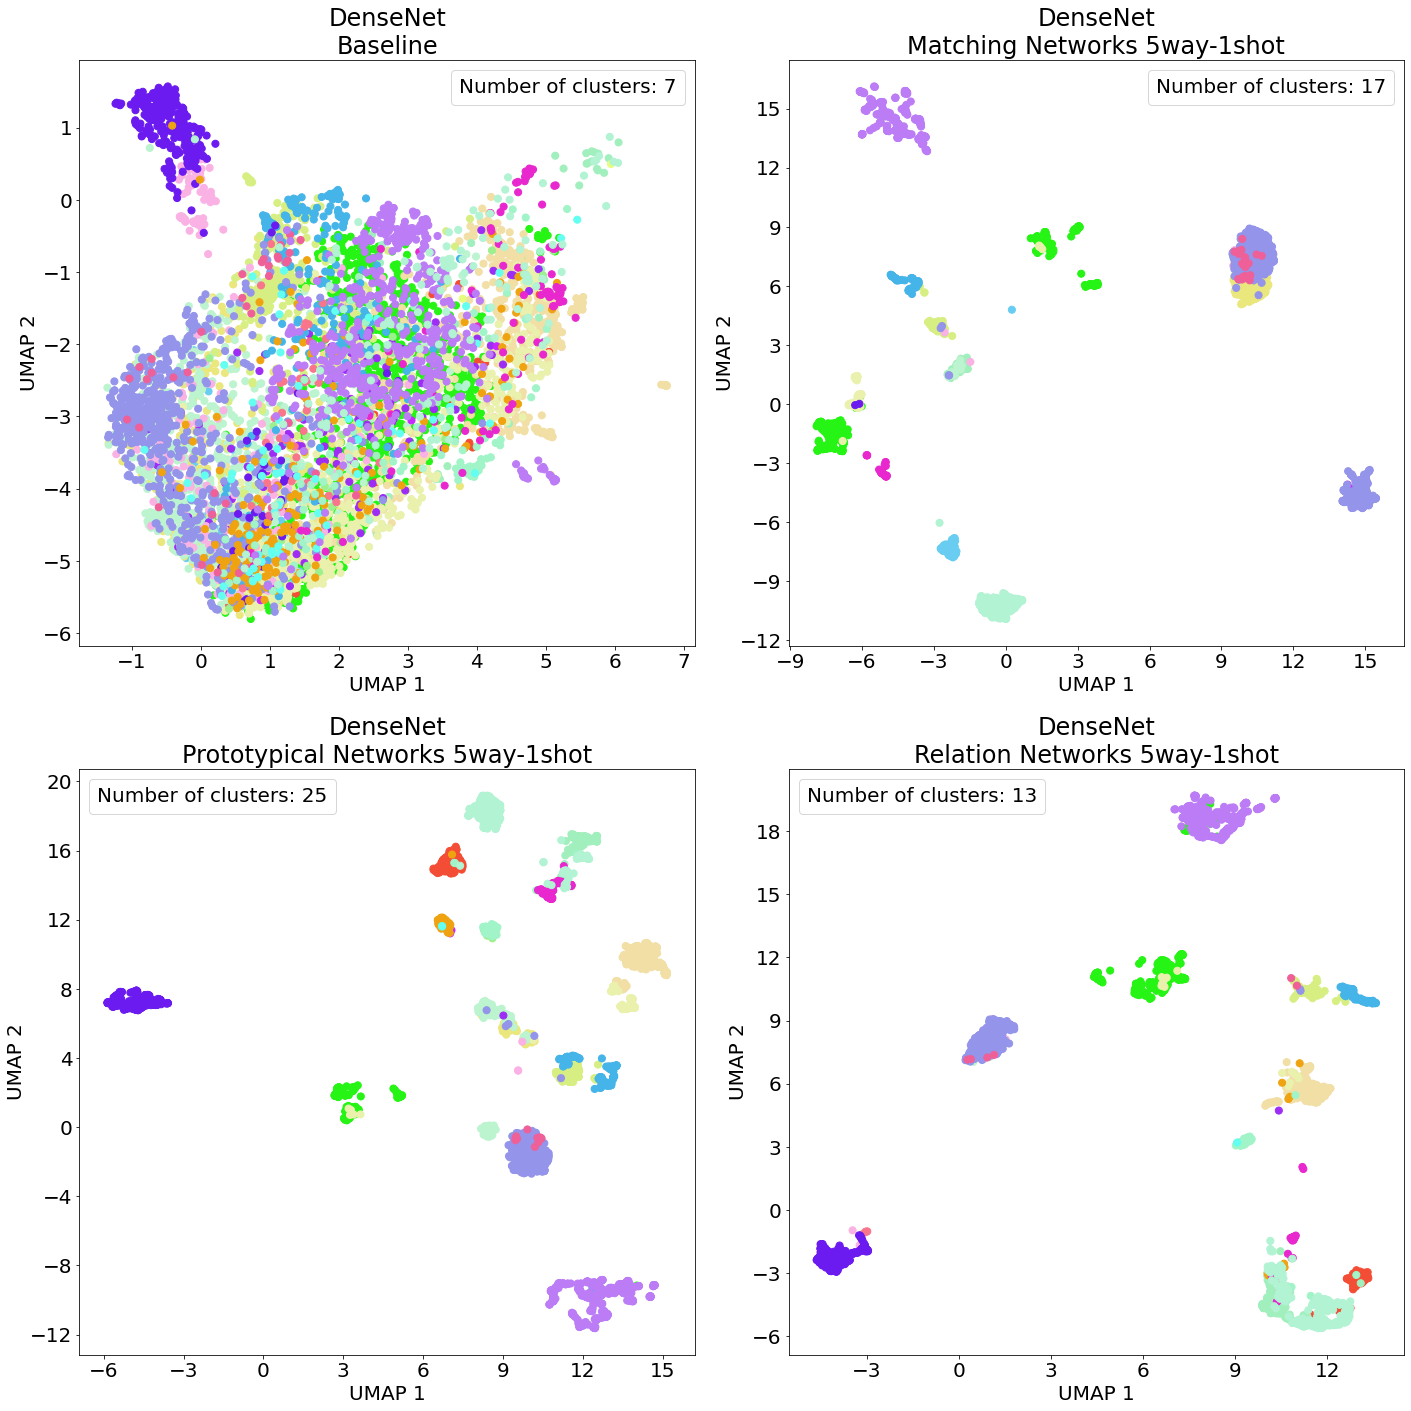

In [8]:
matplotlib.rcParams.update({'font.size': 20})
from matplotlib.ticker import MaxNLocator

# Load vector embeddings
baseline_labels, baseline_plot = plot_embedding('embeddings/features/baseline-densenet-30classes.npy', n_components=5)
mn_labels, mn_plot = plot_embedding('embeddings/features/matching-networks-5way-1shot-densenet-30classes.npy', 20)
pn_labels, pn_plot = plot_embedding('embeddings/features/prototypical-networks-5way-1shot-densenet-30classes.npy', 15)
rn_labels, rn_plot = plot_embedding('embeddings/features/relation-networks-5way-1shot-densenet-30classes.npy', 20)

# Create scatter plots
fig = plt.figure(figsize=(20, 20))
marker_size = 50

ax = fig.add_subplot(2, 2, 1)
ax.set_title('DenseNet\nBaseline')
ax.scatter(baseline_plot[baseline_labels >= 0].T[0], baseline_plot[baseline_labels >= 0].T[1], 
           s=marker_size, c=true_labels[baseline_labels >= 0],
           cmap=new_cmap, label=f'Number of clusters: {len(np.unique(baseline_labels))-1}') 
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True)
for item in leg.legendHandles:
    item.set_visible(False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax = fig.add_subplot(2, 2, 2)
ax.set_title('DenseNet\nMatching Networks 5way-1shot')
ax.scatter(mn_plot[mn_labels >= 0].T[0], mn_plot[mn_labels >= 0].T[1], 
           s=marker_size, c=true_labels[mn_labels >= 0],
           cmap=new_cmap, label=f'Number of clusters: {len(np.unique(mn_labels))-1}')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True)
for item in leg.legendHandles:
    item.set_visible(False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax = fig.add_subplot(2, 2, 3)
ax.set_title('DenseNet\nPrototypical Networks 5way-1shot')
ax.scatter(pn_plot[pn_labels >= 0].T[0], pn_plot[pn_labels >= 0].T[1], 
           s=marker_size, c=true_labels[pn_labels >= 0],
           cmap=new_cmap, label=f'Number of clusters: {len(np.unique(pn_labels))-1}') 
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True)
for item in leg.legendHandles:
    item.set_visible(False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax = fig.add_subplot(2, 2, 4)
ax.set_title('DenseNet\nRelation Networks 5way-1shot')
ax.scatter(rn_plot[rn_labels >= 0].T[0], rn_plot[rn_labels >= 0].T[1],
           s=marker_size, c=true_labels[rn_labels >= 0],
           cmap=new_cmap, label=f'Number of clusters: {len(np.unique(rn_labels))-1}')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True)
for item in leg.legendHandles:
    item.set_visible(False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
# plt.savefig('plot.jpg', dpi=300);